- find 50 most common fragments in each subpocket
- cluster these fragments using Butina clustering
- show 50 most common fragments sorted by cluster

In [221]:
import glob
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
# clustering
from rdkit.Chem import rdFingerprintGenerator
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

from rdkit import DataStructs
from rdkit.ML.Cluster import Butina

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [222]:
path_to_library = '/home/paula/Masterarbeit/FragmentLibrary/'

# list of folders for each subpocket
subpockets = ['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X']
folders = [path_to_library+subpocket for subpocket in subpockets]

In [223]:
# read data

data = pd.DataFrame()

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    smiles = []
    groups = []

    for frag in suppl:
        # remove dummy atoms from fragments and create smiles
        du = Chem.MolFromSmiles('*')
        h = Chem.MolFromSmiles('[H]', sanitize=False)
        fixed_frag = AllChem.ReplaceSubstructs(frag, du, h, replaceAll=True)[0]
        fixed_frag = Chem.RemoveHs(fixed_frag)
        # smiles for comparing fragments
        s = Chem.MolToSmiles(fixed_frag)
        smiles.append(s)
        # 2D coordinates
        tmp = AllChem.Compute2DCoords(fixed_frag)
        fragments.append(fixed_frag)
        # kinase group
        groups.append(frag.GetProp('group'))
     
    df['smiles'] = smiles
    df['fragment'] = fragments
    df['subpocket'] = subpocket
    df['group'] = groups
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(7486, 4)

In [224]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

Functions for clustering:

In [225]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    fp_list = list(fp_list)
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

In [226]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [227]:
cutoff = 0.6

## Adenine pocket:

In [228]:
frag_counts = df_AP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

In [229]:
# Draw.MolsToGridImage(mols, legends=[str(count) for count in mol_counts], molsPerRow=6)

In [230]:
fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  17
# clusters with only 1 compound:  8


In [231]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [232]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_ap.png')

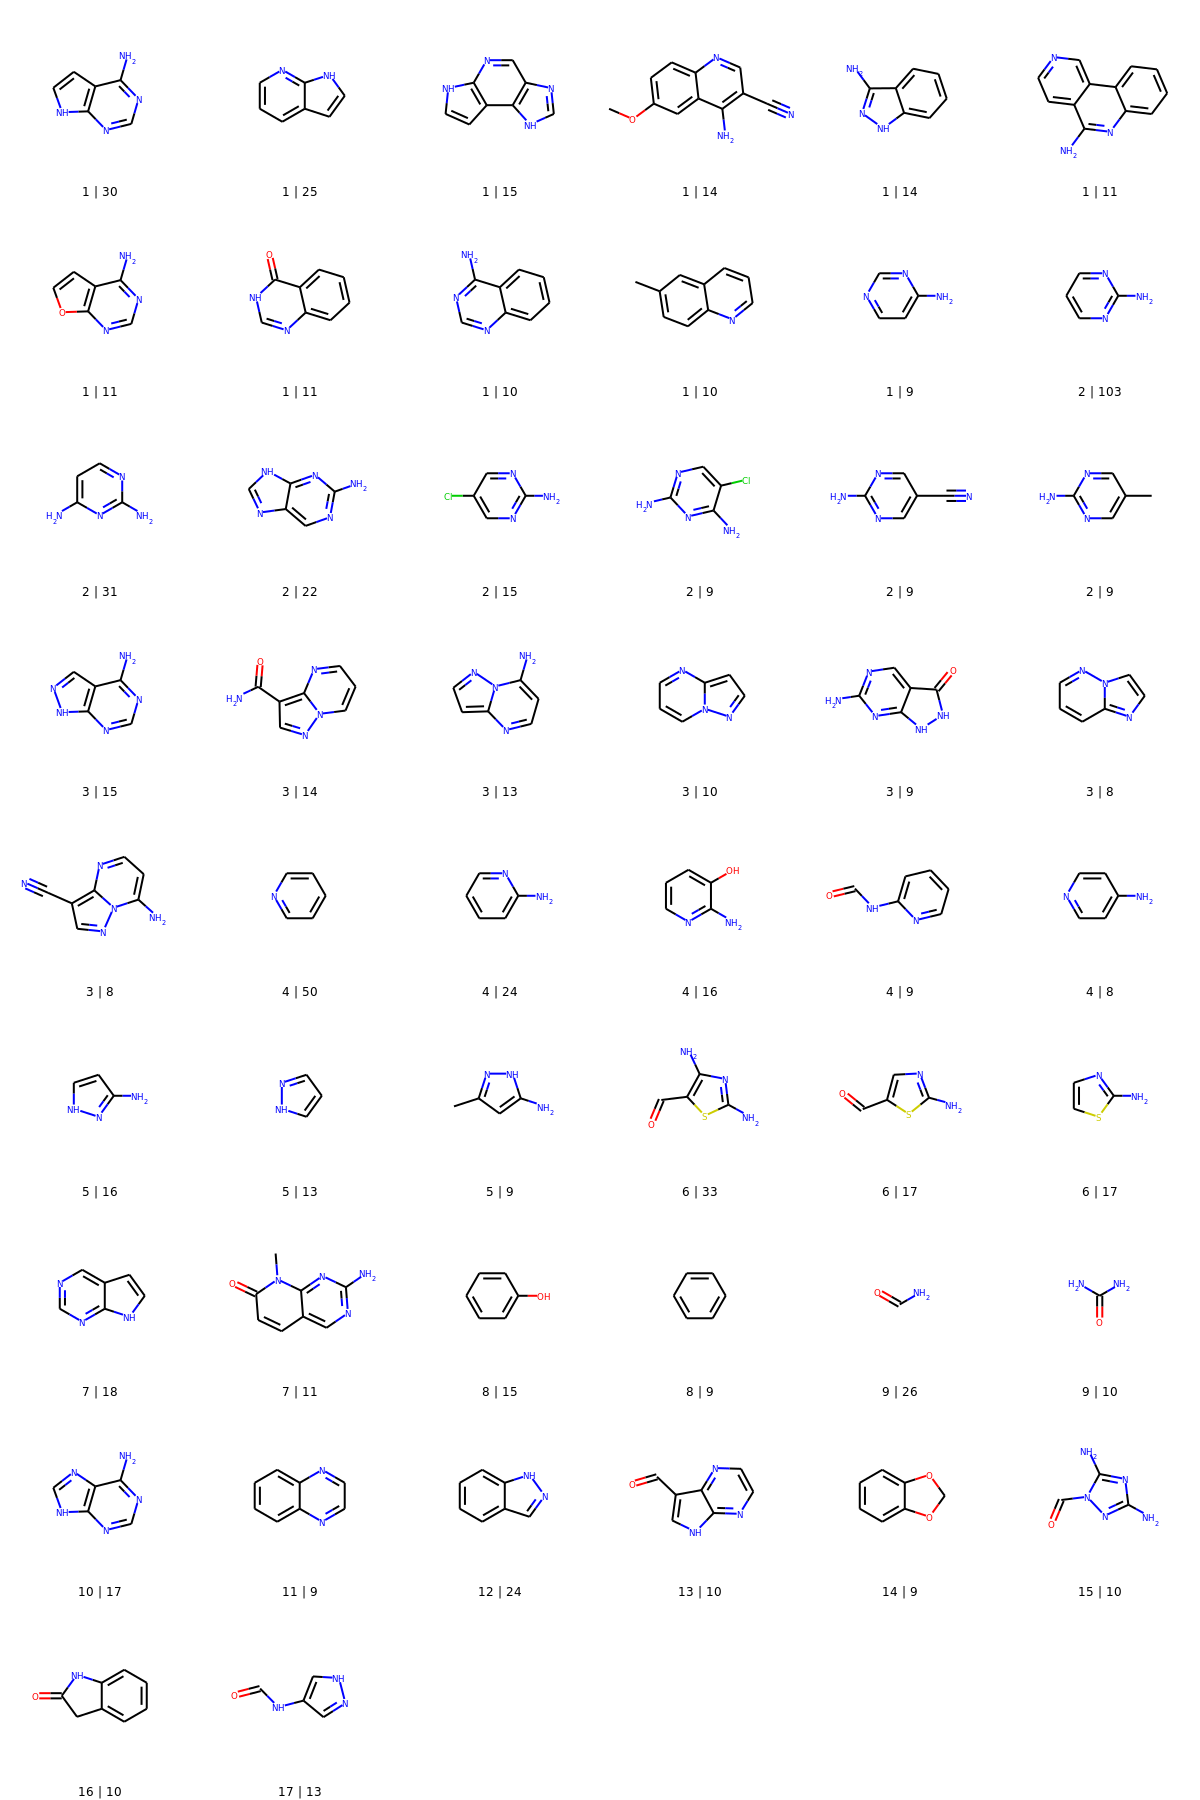

In [233]:
img

## Front pocket:

In [234]:
frag_counts = df_FP.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

In [235]:
fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  21
# clusters with only 1 compound:  8


In [236]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [237]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_fp.png')

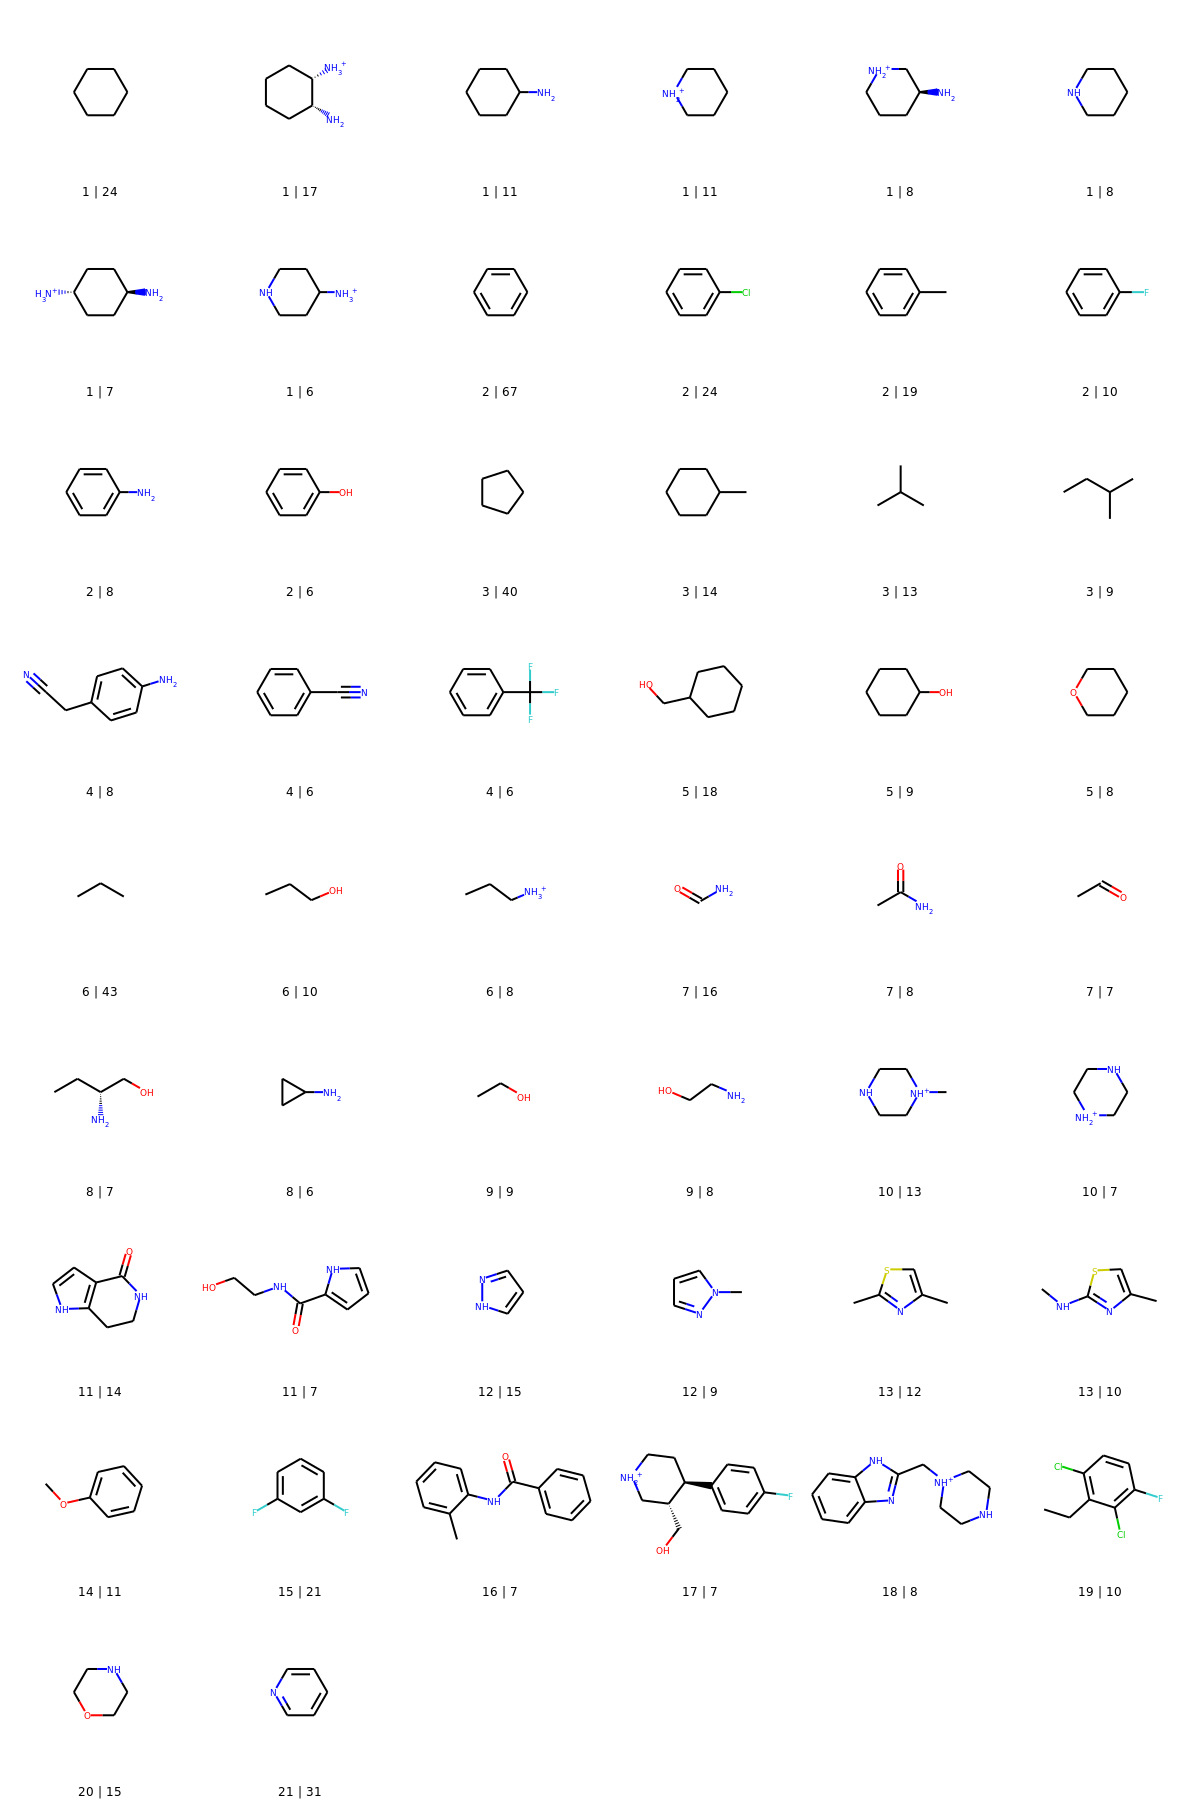

In [238]:
img

## Solvent-exposed pocket:

In [239]:
frag_counts = df_SE.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  23
# clusters with only 1 compound:  11


In [240]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [241]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_se.png')

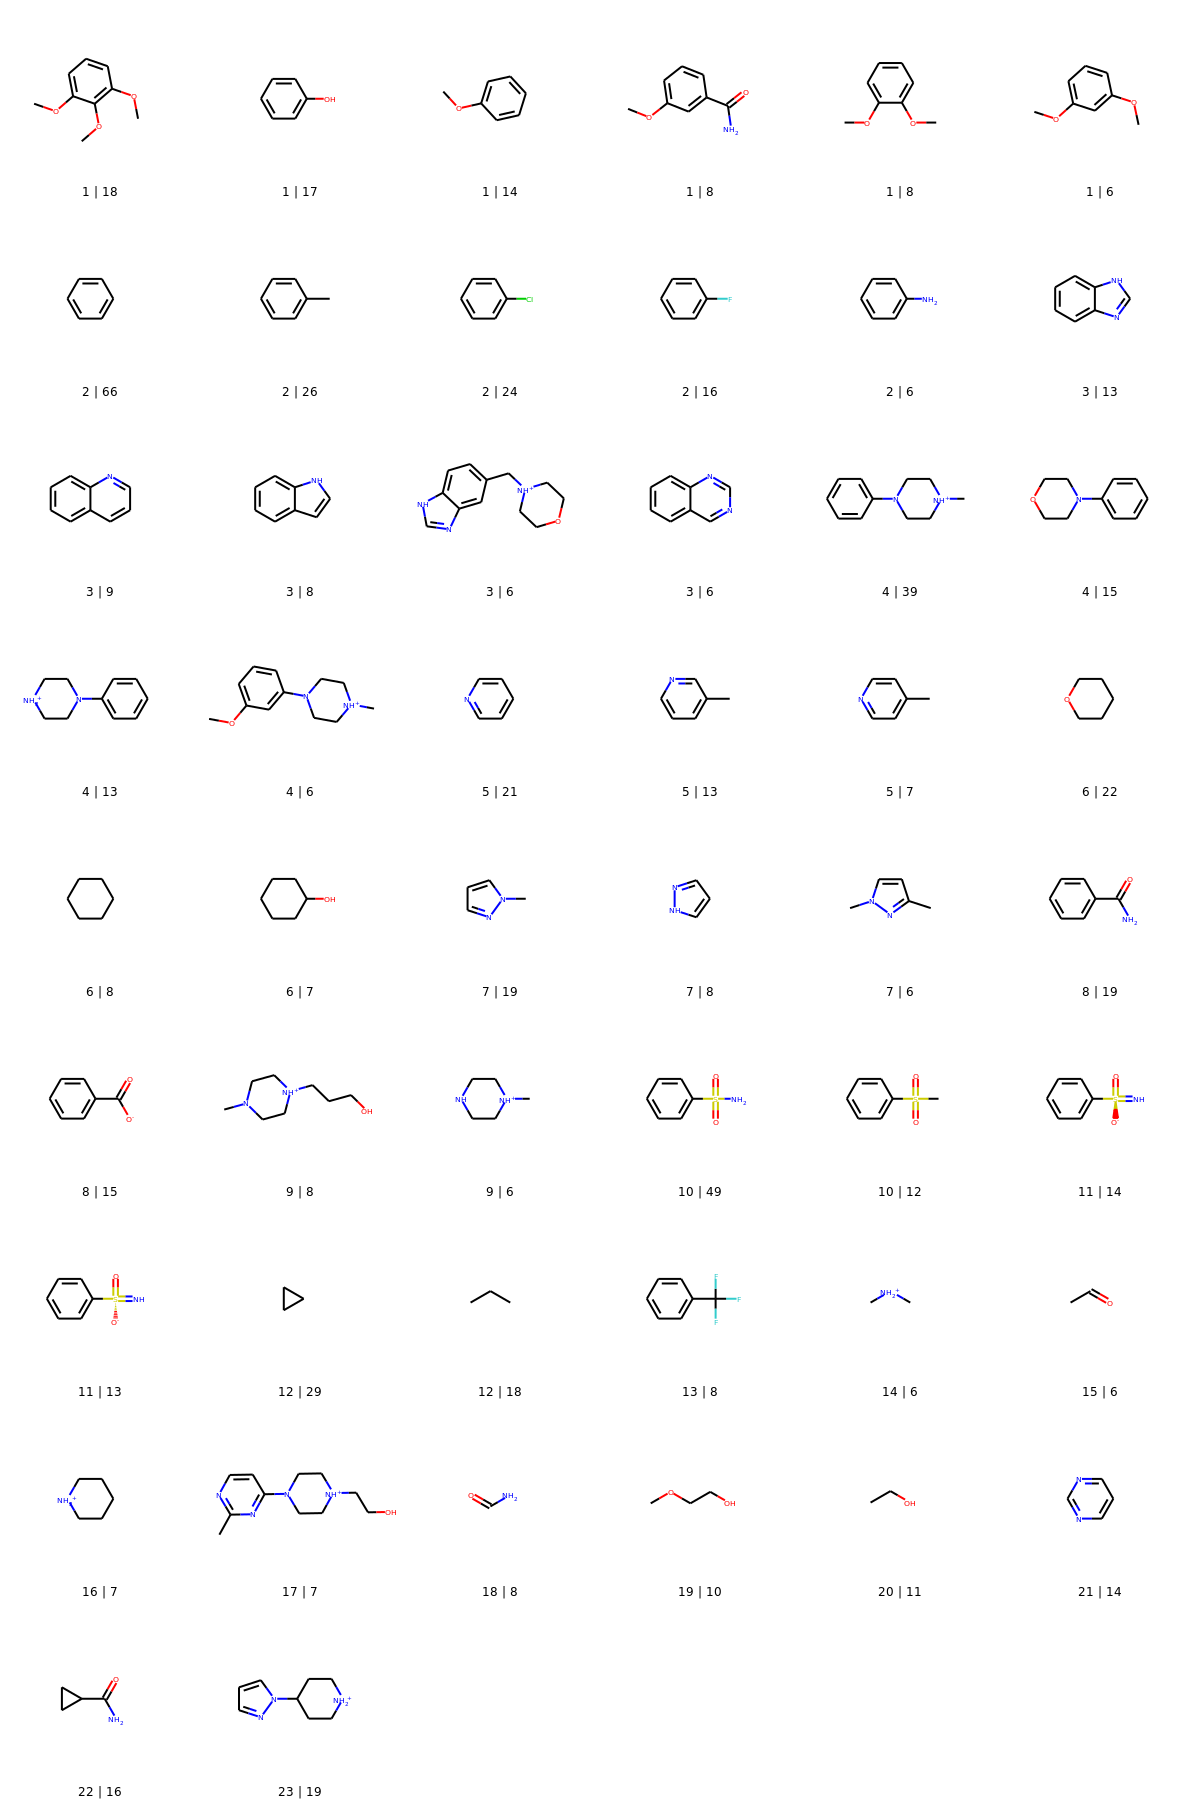

In [242]:
img

## Gate area:

In [243]:
frag_counts = df_GA.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 50
Threshold:  0.6
# clusters:  20
# clusters with only 1 compound:  11


In [244]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [245]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_ga.png')

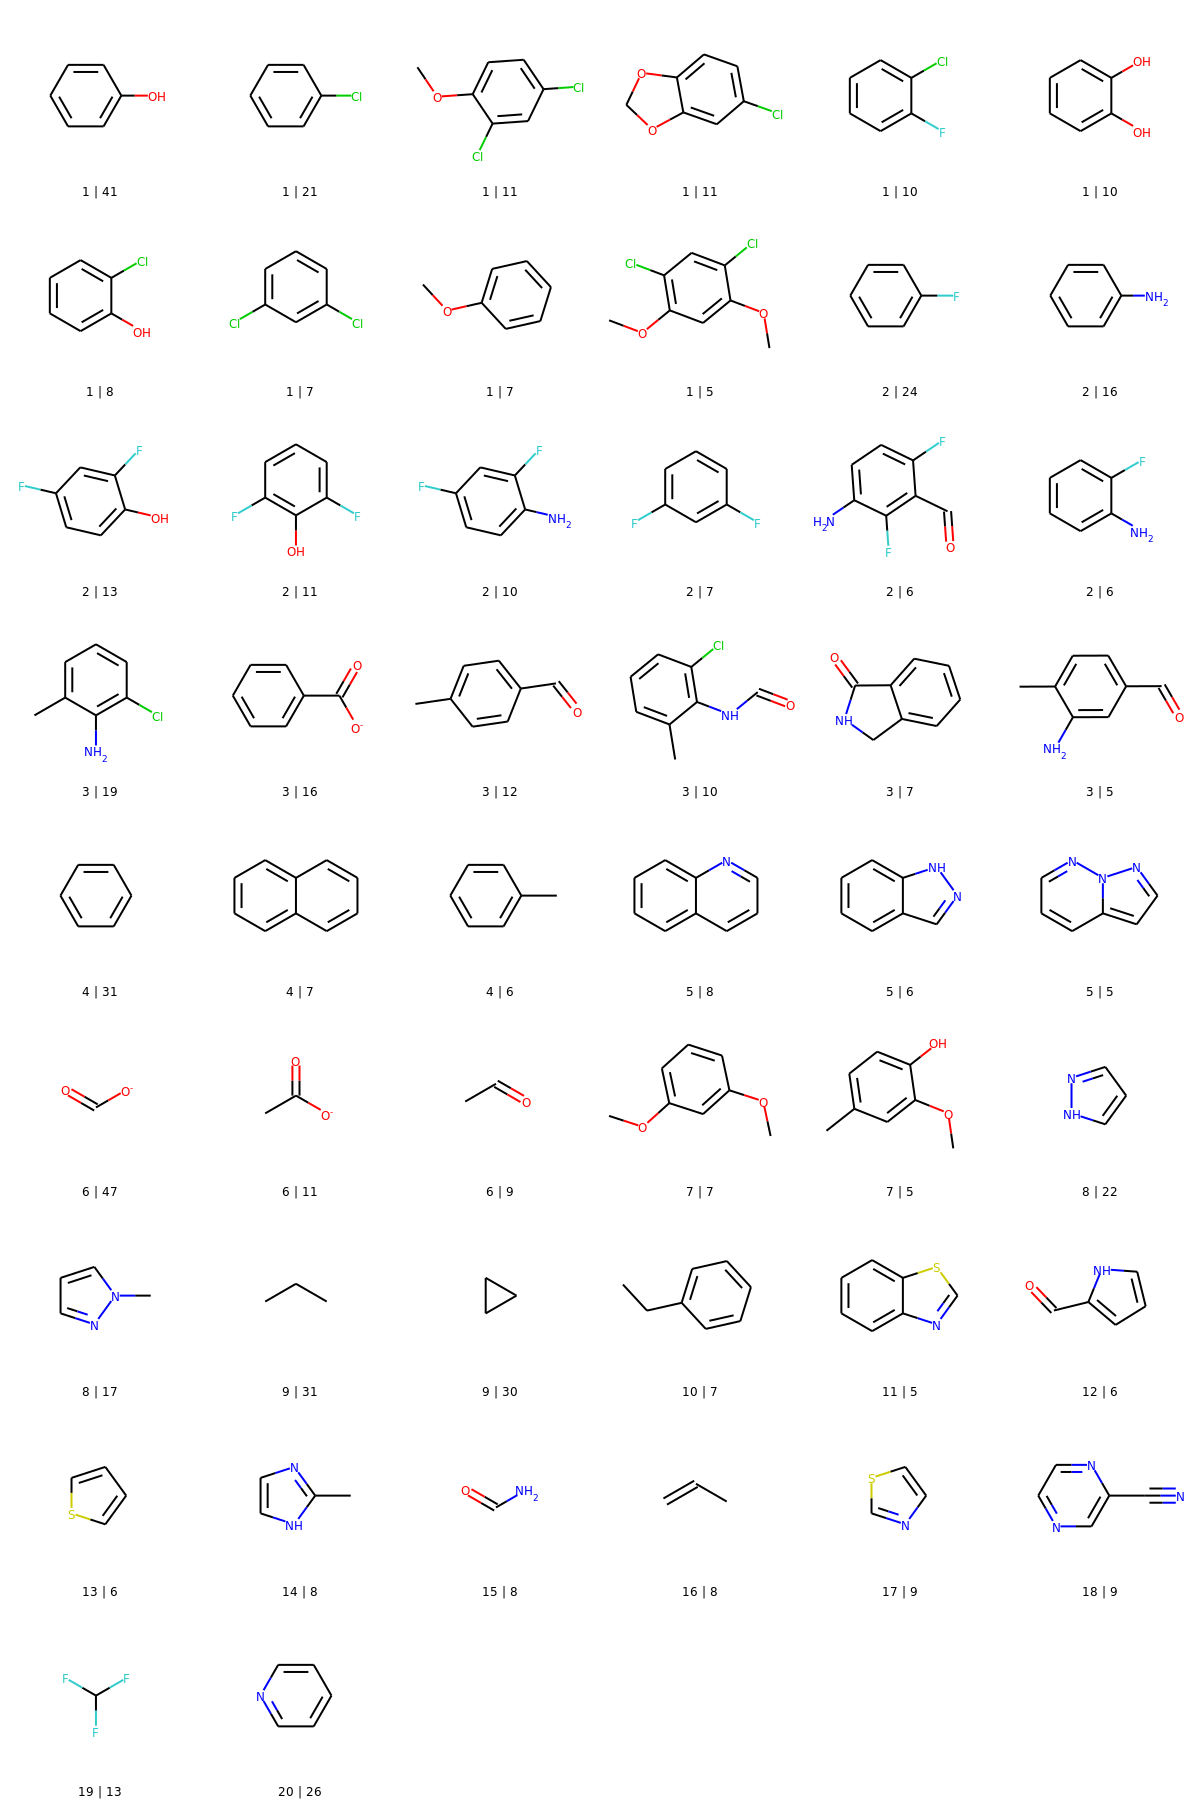

In [246]:
img

## Back pocket I:

In [247]:
frag_counts = df_B1.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 42
Threshold:  0.6
# clusters:  25
# clusters with only 1 compound:  17


In [248]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [249]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_b1.png')

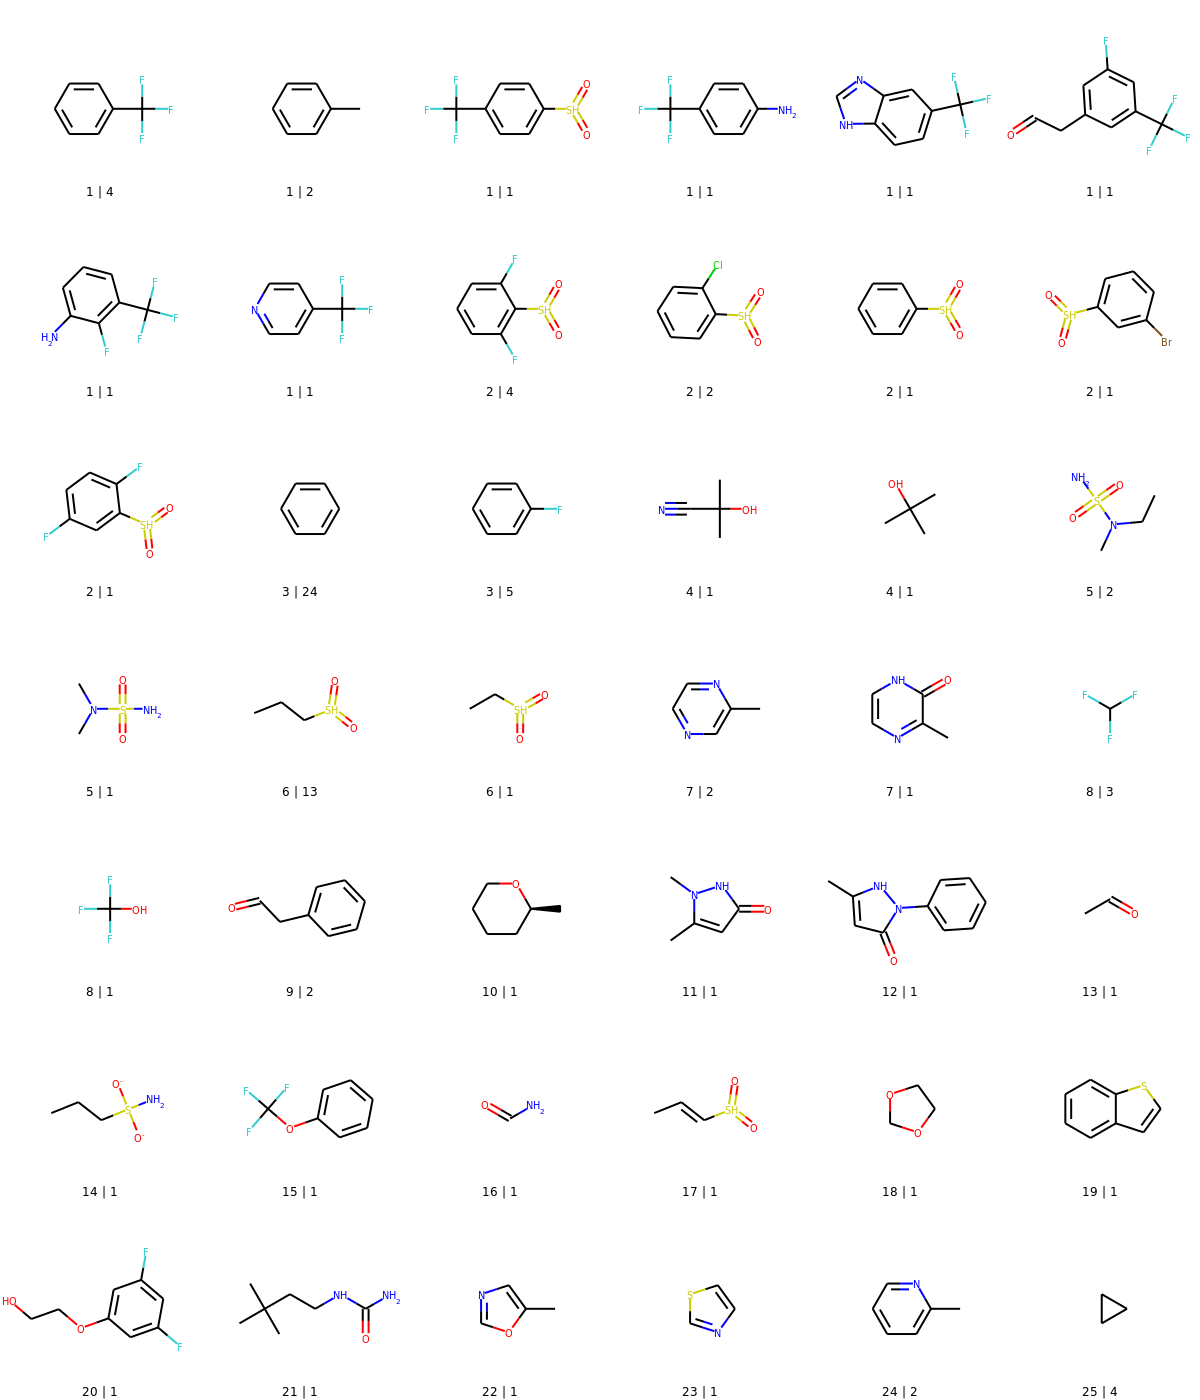

In [250]:
img

## Back pocket II:

In [251]:
frag_counts = df_B2.smiles.value_counts()
frags_max = [Chem.MolFromSmiles(smiles) for smiles in frag_counts.index]
# 50 most common fragments
mols = frags_max[:50]
mol_counts = frag_counts[:50]

fps = [rdkit_gen.GetFingerprint(frag) for frag in mols]

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
print("# fragments:", len(fps))    
print("Threshold: ", cutoff)
print("# clusters: ", len(clusters))
num_clust_g1 = len([c for c in clusters if len(c) == 1])
print("# clusters with only 1 compound: ", num_clust_g1)

# fragments: 43
Threshold:  0.6
# clusters:  30
# clusters with only 1 compound:  24


In [252]:
clustered_mols = []
legends = []
for c, cluster in enumerate(clusters):
    # combine mols and counts
    cluster_mols = pd.DataFrame(list(zip([mols[i] for i in cluster], [mol_counts[i] for i in cluster])), \
                                columns = ['mol', 'count']) \
                                .sort_values(by='count', ascending=False)
    clustered_mols.extend(list(cluster_mols.mol))
    legends.extend([str(c+1) + ' | ' + str(count) for count in cluster_mols['count']])

In [253]:
img = Draw.MolsToGridImage(clustered_mols, legends=legends,  molsPerRow=6)
img.save('/home/paula/Masterarbeit/manuscript/Figures/fa_clustered_most_common_b2.png')

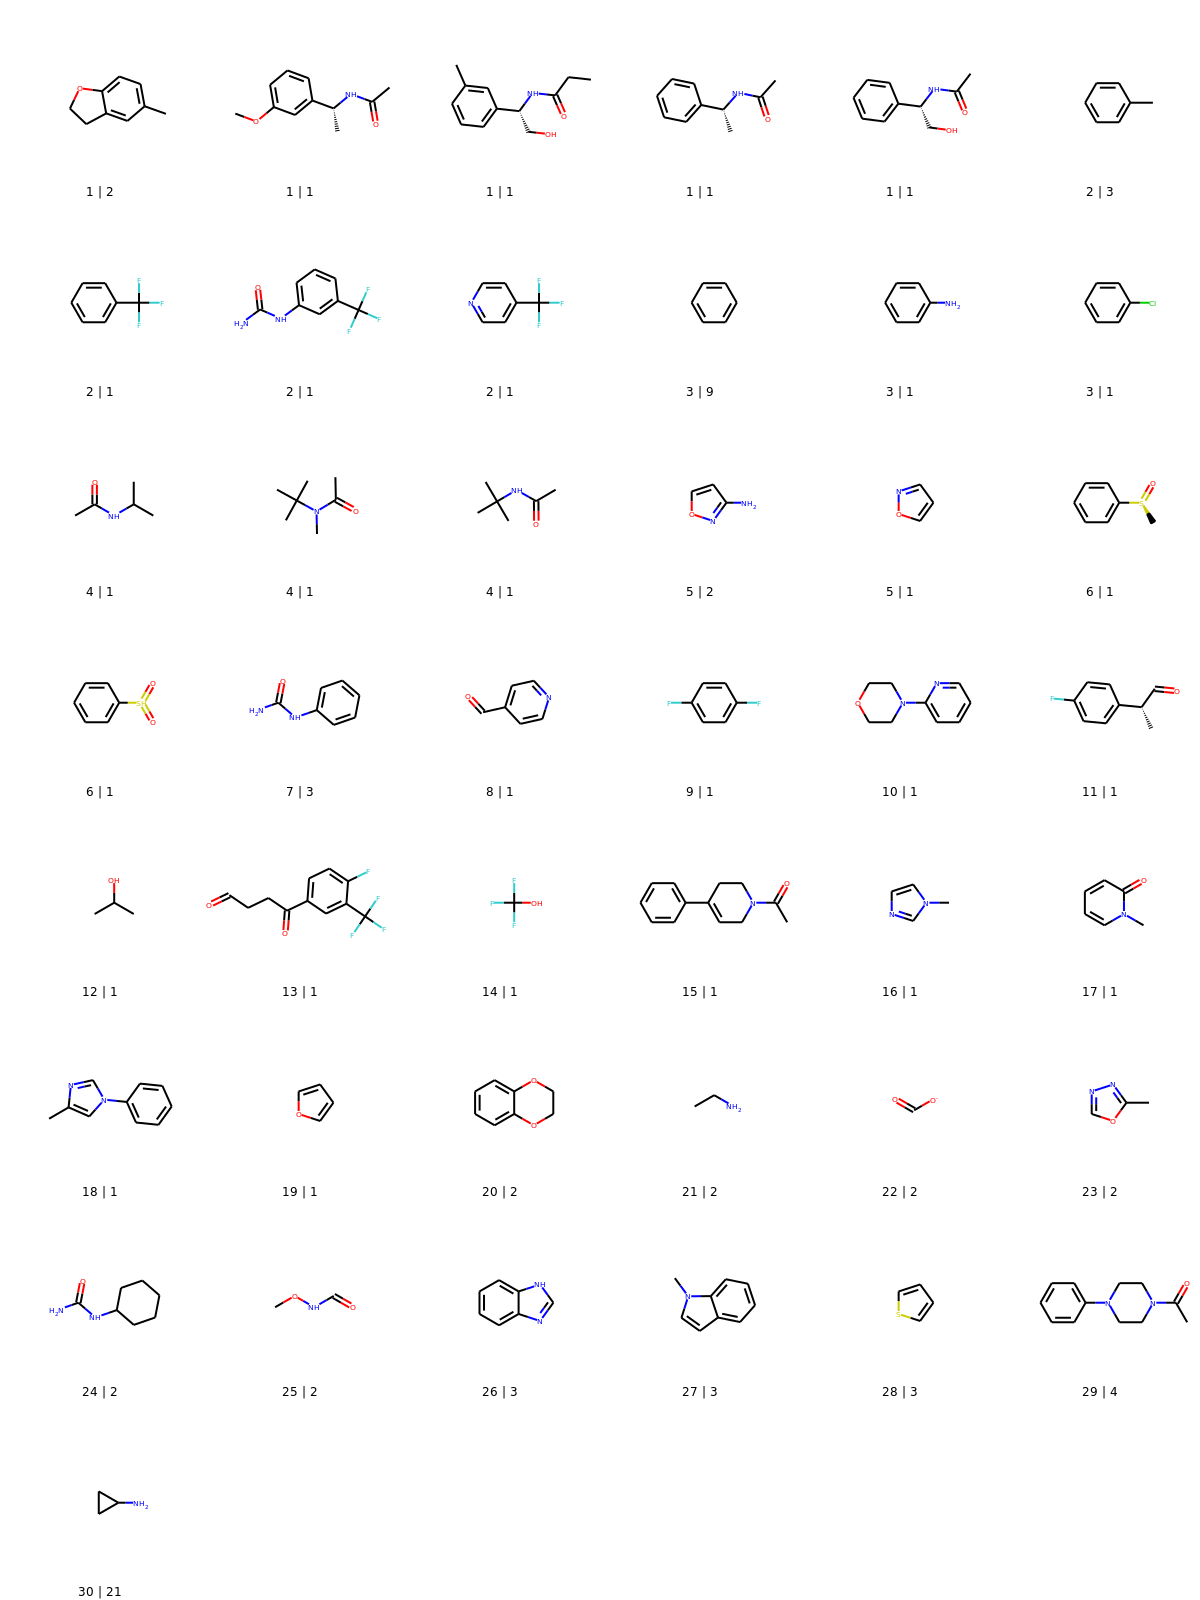

In [254]:
img